In [1]:
import json
import os
import math
import librosa
import os
import fnmatch
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import random
import librosa
import math

In [2]:
with open('data_finaloriginal.json', "r") as f:
    data1 = json.load(f)
    
x1 = data1['mfcc']
y1 = data1['labels']

In [3]:
with open('data_final.json', "r") as f:
    data2 = json.load(f)
    
x2 = data2['mfcc']
y2 = data2['labels']

In [4]:
with open('data_finalpitchlowered.json', "r") as f:
    data3 = json.load(f)
    
x3 = data3['mfcc']
y3 = data3['labels']

In [5]:
with open('data_finalrateboosted.json', "r") as f:
    data4 = json.load(f)
    
x4 = data4['mfcc']
y4 = data4['labels']

In [6]:
with open('data_finalratelowerd.json', "r") as f:
    data5 = json.load(f)
    
x5 = data5['mfcc']
y5 = data5['labels']

In [7]:
import numpy as np

Xargs = (np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5))
yargs = (np.array(y1), np.array(y2), np.array(y3), np.array(y4), np.array(y5))

In [8]:
X = np.concatenate(Xargs)
y = np.concatenate(yargs)

In [9]:
import gc

del data1
del x1
del y1
del data2
del x2
del y2
del data3
del x3
del y3
del data4
del x4
del y4
del data5
del x5
del y5
del Xargs
del yargs

gc.collect()

0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


In [11]:
# input with shape of height=32 and width=128 
inputs = Input(shape=input_shape)

conv_1 = Conv2D(32, (3, 3), activation = 'relu')(inputs)
pool_1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv_1)
batch_norm_1 = BatchNormalization()(pool_1)

conv_2 = Conv2D(32, (3, 3), activation = 'relu')(batch_norm_1)
pool_2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv_2)
batch_norm_2 = BatchNormalization()(pool_2)

conv_3 = Conv2D(32, (2, 2), activation = 'relu')(batch_norm_2)
pool_3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv_3)
batch_norm_3 = BatchNormalization()(pool_3)

squeezed = Lambda(lambda x: tf.squeeze(x, 2))(batch_norm_3)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)

flat = keras.layers.Flatten()(blstm_2)
dense = Dense(64, activation='relu')(flat)
dropout = keras.layers.Dropout(0.3)(dense)

outputs = Dense(10, activation = 'softmax')(dropout)

act_model = Model(inputs, outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130, 13, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0     

In [13]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
act_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = act_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=75)


test_loss, test_acc = act_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/75
918/918 [==============================] - 89s 91ms/step - loss: 1.4483 - accuracy: 0.4850 - val_loss: 1.0665 - val_accuracy: 0.6274
Epoch 2/75
918/918 [==============================] - 81s 89ms/step - loss: 1.1333 - accuracy: 0.6061 - val_loss: 0.9284 - val_accuracy: 0.6822
Epoch 3/75
918/918 [==============================] - 89s 97ms/step - loss: 1.0034 - accuracy: 0.6540 - val_loss: 0.8295 - val_accuracy: 0.7123
Epoch 4/75
918/918 [==============================] - 106s 116ms/step - loss: 0.9075 - accuracy: 0.6855 - val_loss: 0.7691 - val_accuracy: 0.7382
Epoch 5/75
918/918 [==============================] - 100s 109ms/step - loss: 0.8368 - accuracy: 0.7142 - val_loss: 0.6932 - val_accuracy: 0.7638
Epoch 6/75
918/918 [==============================] - 104s 114ms/step - loss: 0.7689 - accuracy: 0.7345 - val_loss: 0.6655 - val_accuracy: 0.7698
Epoch 7/75
918/918 [==============================] - 104s 114ms/step - loss: 0.7147 - accuracy: 0.7546 - val_loss: 0.5943 - val_a

Epoch 57/75
918/918 [==============================] - 102s 111ms/step - loss: 0.1099 - accuracy: 0.9614 - val_loss: 0.2596 - val_accuracy: 0.9268
Epoch 58/75
918/918 [==============================] - 111s 121ms/step - loss: 0.1121 - accuracy: 0.9608 - val_loss: 0.2194 - val_accuracy: 0.9384
Epoch 59/75
918/918 [==============================] - 101s 110ms/step - loss: 0.1065 - accuracy: 0.9643 - val_loss: 0.1849 - val_accuracy: 0.9437
Epoch 60/75
918/918 [==============================] - 100s 109ms/step - loss: 0.1043 - accuracy: 0.9651 - val_loss: 0.2064 - val_accuracy: 0.9406
Epoch 61/75
918/918 [==============================] - 96s 105ms/step - loss: 0.1024 - accuracy: 0.9651 - val_loss: 0.2065 - val_accuracy: 0.9380
Epoch 62/75
918/918 [==============================] - 96s 105ms/step - loss: 0.1017 - accuracy: 0.9643 - val_loss: 0.1777 - val_accuracy: 0.9452
Epoch 63/75
918/918 [==============================] - 108s 118ms/step - loss: 0.1000 - accuracy: 0.9671 - val_loss: 0.2

In [14]:
print('\nTest accuracy:', test_acc)


Test accuracy: 0.9439313411712646


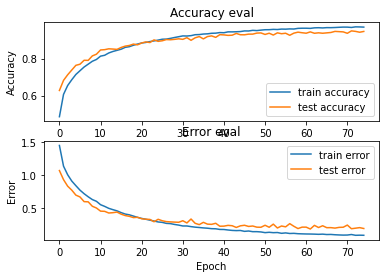

In [15]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()
    
plot_history(history)